## 1. import all required modules

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.layers import Embedding, Dense, LSTM

Using TensorFlow backend.


## 2. Load Data

Dataset used: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/)

In [2]:
data = pd.read_csv('./IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

## 3. Preprocessing reviews

As reviews contain HTML tags, [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is helpful for getting only the text from reviews.

In [4]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def clean_text(raw_text):
    text = remove_html(raw_text)
    return text

In [5]:
data['review'] = data['review'].apply(clean_text)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 4. Tokenize words in reviews

Consider only 10000 most frequenlty used words (```vocab_size```) in reviews for tokenization and only first 100 words (```max_len```) in a review. 

In [6]:
# maximum number of words to keep, based on word frequency
vocab_size = 10000

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
word_index = tokenizer.word_index

In [7]:
# maximum length of all sequences
max_len = 100

x = sequence.pad_sequences(sequences, maxlen=max_len)

In [8]:
sentiments = {
    'positive': 1,
    'negative': 0
}

y = np.asarray(data['sentiment'].map(sentiments))

## 5. Split data

Split 60% of data for training, 20% of data for cross validation and 20% data for testing. 

In [9]:
train_samples = 40000

x_train = x[:train_samples]
y_train = y[:train_samples]

x_test = x[train_samples:]
y_test = y[train_samples:]

## 6. Load GloVe Embedding Vectors

Load [GloVe](https://nlp.stanford.edu/projects/glove/) file with 100 Dimension vector into ```embedding_index```.

In [10]:
def load_glove(path):
    
    embedding_index = {}
    for line in open(path):
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeff
    
    return embedding_index

In [11]:
embedding_index = load_glove('./glove.6B.100d.txt')

## 7. Prepare embedding matrix

Prepare embedding matrix of shape (```vocab_size```, ```embedding_dim```) using vectors from ```embedding_index```.

In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in word_index.items():
    if index < vocab_size:
        vector = embedding_index.get(word);
        if vector is not None:
            embedding_matrix[index] = embedding_index.get(word)

print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (10000, 100)


In [13]:
# check for successful embedding matrix

embedding_matrix[word_index.get('the')] == embedding_index.get('the')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 8. Prepare and train model

Prepare model and load weights of ```embedding_matrix``` and set the embedding layer to ```trainable = False```

In [14]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,017,569
Trainable params: 17,569
Non-trainable params: 1,000,000
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [16]:
epochs = 5
batch_size = 32
val_split = 0.2

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split)
model.save('imdb_sentiment_analysis.h5')

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 73s 2ms/step - loss: 0.5033 - acc: 0.7502 - val_loss: 0.4252 - val_acc: 0.8034
Epoch 2/5
32000/32000 [==============================] - 66s 2ms/step - loss: 0.3913 - acc: 0.8217 - val_loss: 0.3806 - val_acc: 0.8279
Epoch 3/5
32000/32000 [==============================] - 69s 2ms/step - loss: 0.3558 - acc: 0.8422 - val_loss: 0.3603 - val_acc: 0.8393
Epoch 4/5
32000/32000 [==============================] - 80s 2ms/step - loss: 0.3327 - acc: 0.8520 - val_loss: 0.3473 - val_acc: 0.8460
Epoch 5/5
32000/32000 [==============================] - 73s 2ms/step - loss: 0.3165 - acc: 0.8607 - val_loss: 0.3508 - val_acc: 0.8471


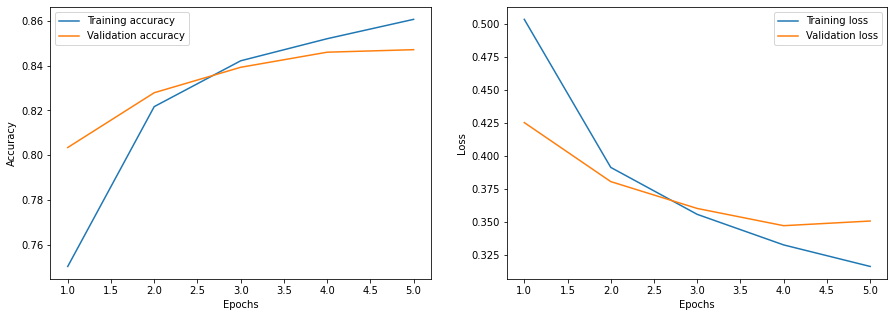

In [17]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs_range = range(1, epochs + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs_range, acc_values, label='Training accuracy')
ax[0].plot(epochs_range, val_acc_values, label='Validation accuracy')
ax[0].set(xlabel='Epochs', ylabel='Accuracy')
ax[0].legend()

ax[1].plot(epochs_range, loss_values, label='Training loss')
ax[1].plot(epochs_range, val_loss_values, label='Validation loss')
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].legend()

## 9. Test model on testing samples

In [18]:
scores = model.evaluate(x_test, y_test)
print('Loss: {}'.format(scores[0]))
print('Accuracy: {}'.format(scores[1]))

10000/10000 [==============================] - 4s 393us/step
Loss: 0.3507034780025482
Accuracy: 0.8429999947547913
